In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches
import matplotlib
import sys
import os
import numpy as np
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())

rb = LinearSegmentedColormap.from_list(
    "rb", [rgb.tue_blue, [1, 1, 1], rgb.tue_red], N=500
)

wg = LinearSegmentedColormap.from_list(
    "wg", [[1, 1, 1], rgb.tue_gold], N=500
)


from netCDF4 import Dataset
import xarray as xr
import cartopy.crs as ccrs  # plotting library for geospatial data

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

Import Data

In [71]:
data = xr.open_dataset("../dat/NOAAGlobalTemp_v5.0.0_gridded_s188001_e202212_c20230108T133308.nc")
df = data.to_dataframe()
df.head()

anom
time       lat   lon  z        
1880-01-01 -87.5 2.5  0.0   NaN
                 7.5  0.0   NaN
                 12.5 0.0   NaN
                 17.5 0.0   NaN
                 22.5 0.0   NaN

In [80]:
data["anom"][-1]

<xarray.DataArray 'anom' (z: 1, lat: 36, lon: 72)>
array([[[  nan,   nan, ...,   nan, -3.07],
        [  nan,   nan, ...,   nan,   nan],
        ...,
        [  nan,   nan, ...,   nan,   nan],
        [  nan,   nan, ...,   nan,   nan]]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-12-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Attributes:
    long_name:              Global Temperature Anomalies
    standard_name:          surface_temperature_anomaly
    coverage_content_type:  physicalMeasurement
    units:                  degrees C
    valid_min:              -40.0
    valid_max:              40.0

Text(0.5, 1.0, 'Surface Temperature Anomalies - 12.01.2022')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

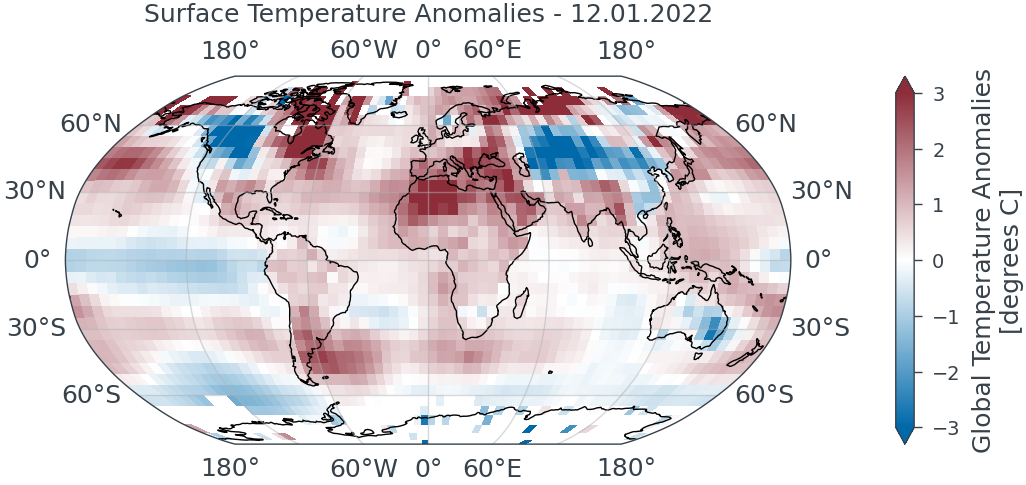

In [81]:
# Create a plot
plt.rcParams.update(bundles.beamer_moml())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines()
data["anom"][-1].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin=-3, vmax=3)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=.5,
    color=rgb.tue_gray,
    alpha=0.5,
    linestyle="-",
)
gl.top_labels = True
gl.right_labels = True

plt.title("Surface Temperature Anomalies - 12.01.2022")

In [106]:
df = pd.read_csv(os.path.relpath('../dat/temp_anomalies_mothly/box.1.v5.0.0.202212.txt'), delim_whitespace=True)
df.columns = ["year", "lat", "lon", "z", "anom"]
df.head
df = df[df["year"] == 2020]
df = df[["lat", "lon", "anom"]]

        lat    lon  anom
97151  12.5  102.5  2.47
97152 -12.5  107.5  1.37
97153  12.5  107.5  1.61
97154 -12.5  122.5  1.31
97155  12.5  122.5  1.53
...     ...    ...   ...
98021  82.5  -17.5 -0.25
98022  82.5   57.5  5.44
98023 -82.5   77.5 -2.74
98024 -87.5   -2.5 -2.64
98025 -87.5   87.5 -3.23

[875 rows x 3 columns]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

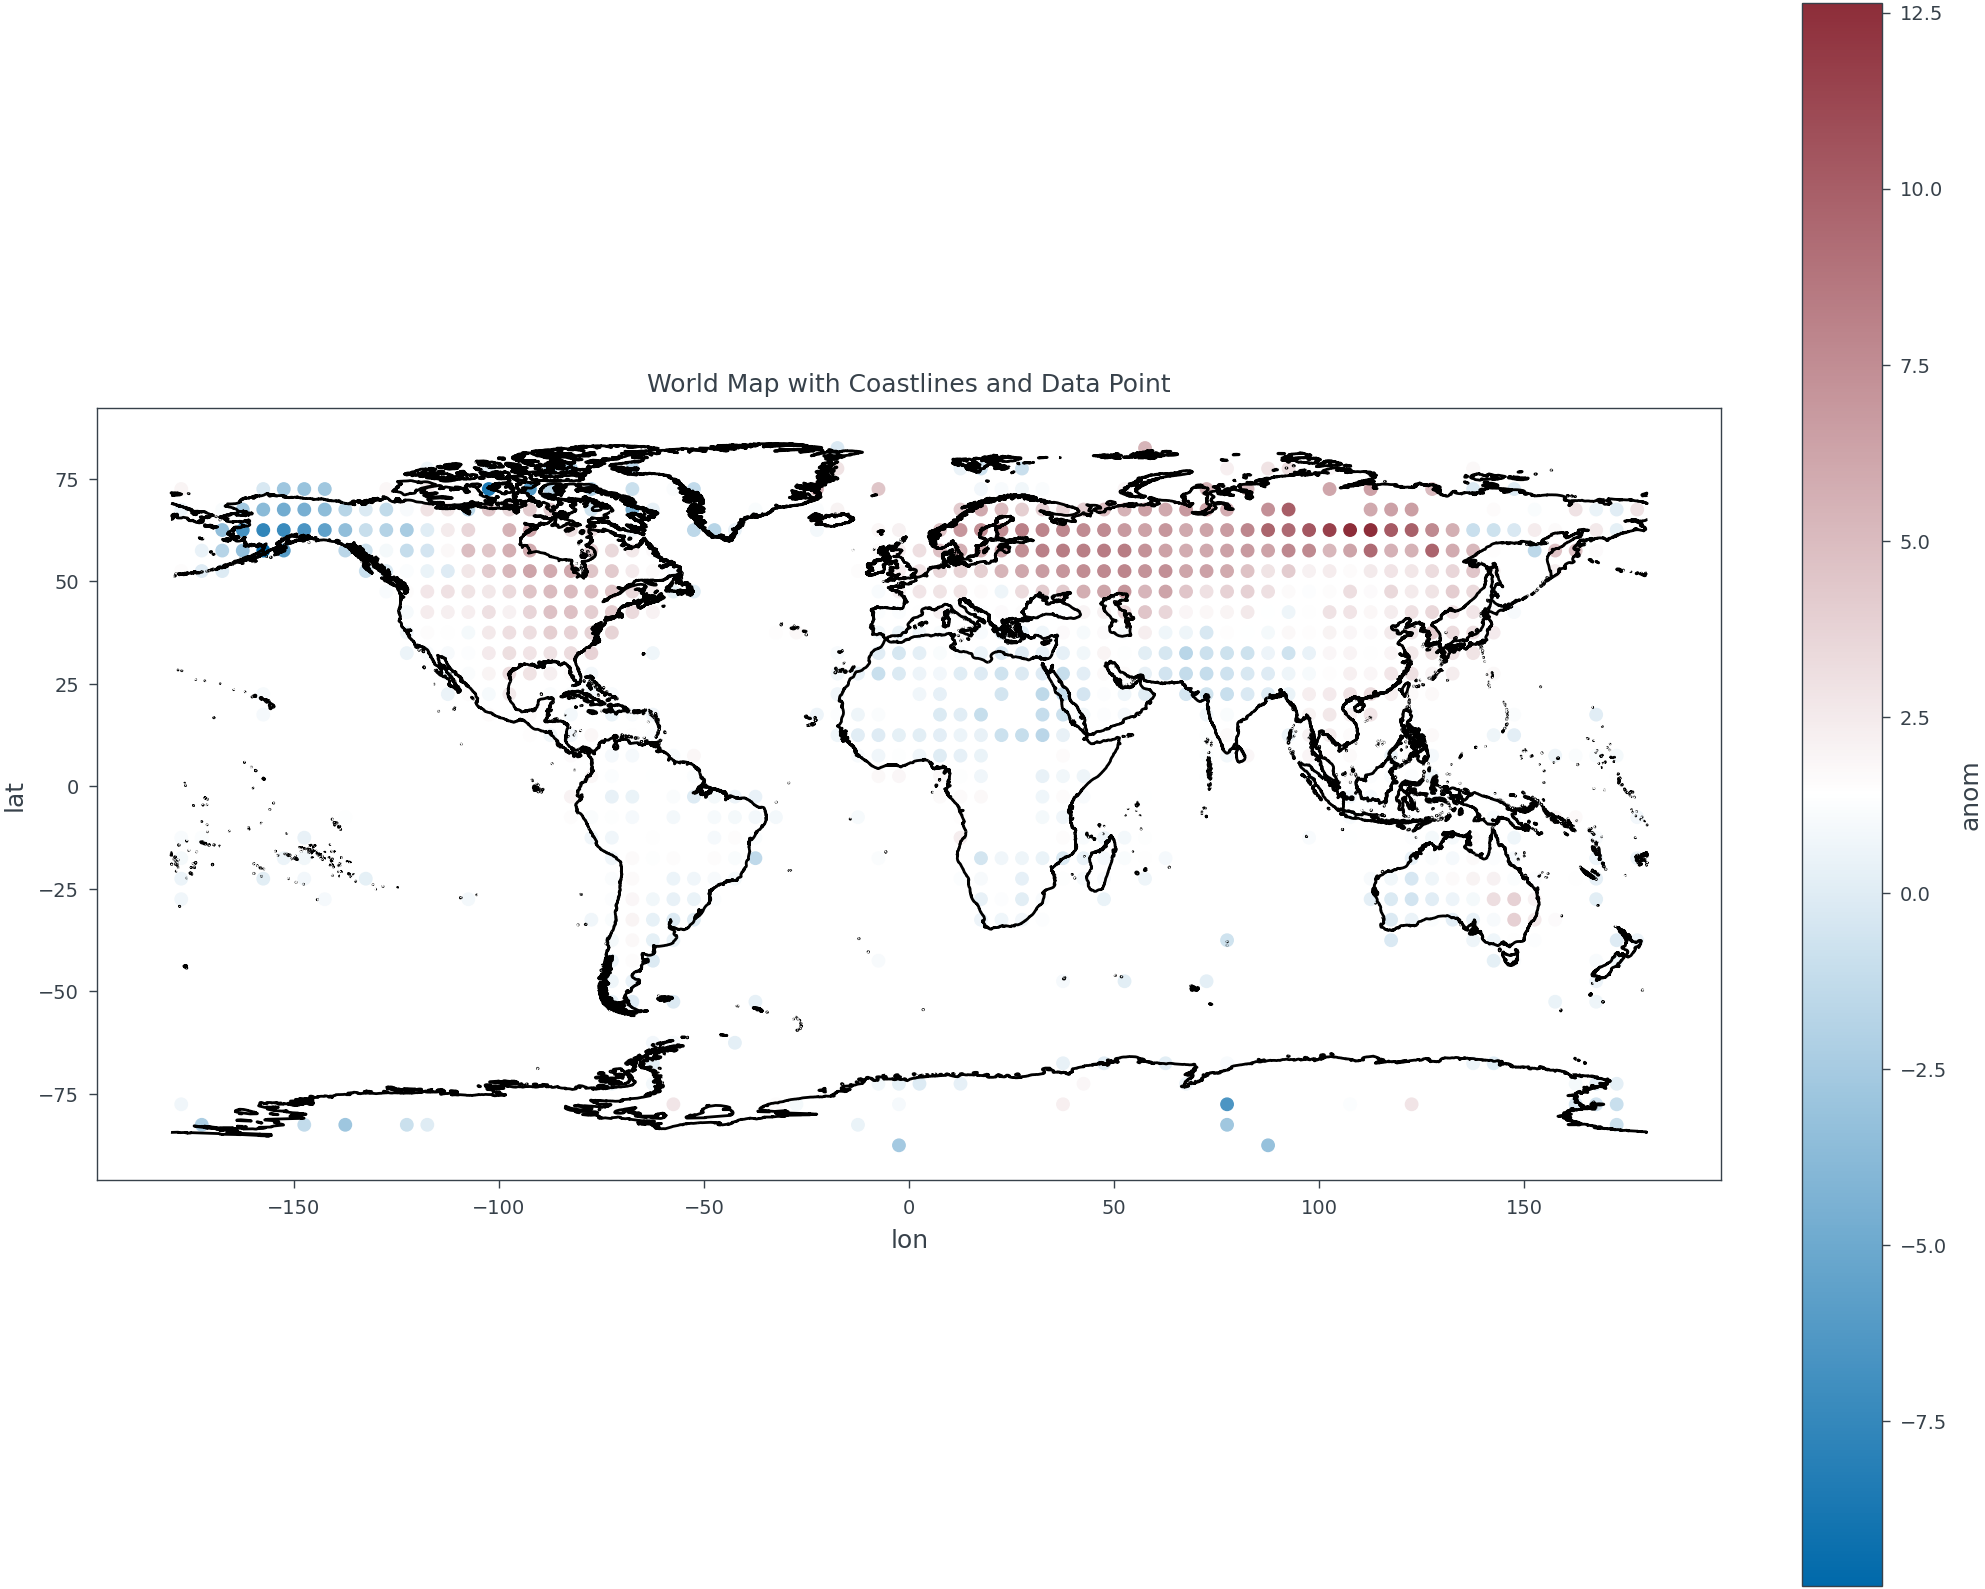

In [118]:
from shapely.geometry import Point
import geopandas as gpd

# Load world countries shapefile with coastlines from Natural Earth
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load world coastlines shapefile from Natural Earth
#coastlines = gpd.read_file(gpd.datasets.get_path('naturalearth_coastline')) 
coastlines = gpd.read_file(os.path.relpath('../dat/naturalearth/ne_10m_coastline.shp')) 


#point = gpd.GeoDataFrame(geometry=[Point(longitude, latitude)], crs="EPSG:4326")

# Plot the world map with coastlines
fig, ax = plt.subplots(figsize=(10, 8))
coastlines.plot(ax=ax, color='black')


df.plot(ax = ax, x="lon", y="lat", kind="scatter", c="anom",
        colormap=rb)


#df.plot(x='lat', y = 'lon', c ='anom', colormap=rb, vmin=-3, vmax=3)

#point.plot(ax=ax, marker='o', color='red', markersize=50)  # Plot the data point in red

# Set plot title
plt.title('World Map with Coastlines and Data Point')

# Show the plot
plt.show()
